# Stability and convergence criteria for the linear response

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = '/linear-response'

Autosave disabled


The aim of this notebook is to perform an assessment of the reliability of the results given by the linear response. 
First of all we analyze the absorption spectrum and discuss its stability in terms of both the number of virtual orbitals and the dimension of the simulation box. 
Then we try to define a set of tools for perfoming a (semi)-automatic analysis of the excitonic states of the system. We want to define a procedure that is able to state if a given excitation can be considered as "well-sampled" or not (using the given values of number of virtual states and dimension of the simulation box)

## Construction of the relevant dictionaries

We set some general parameters and perform the analysis reading the results obtained in the others notebook

In [2]:
numOrb = 5
simSetup = {
    'free-bc' : {'rmult' : [7.0,9.0], 'nVirtMax' : [303,279]},
    'periodic-bc' : {'rmult' :[7.0], 'nVirtMax' : [296]}
    }

In [3]:
simSetup['free-bc']['rmult']

[7.0, 9.0]

In [4]:
statPol = {}
spectrum = {}
excitations = {}
Data = {}
for bc,s in simSetup.iteritems():
    statPol[bc] = {}
    spectrum[bc] = {}
    excitations[bc] = {}
    Data[bc] = {}
    
    path = bc+outputpath
    print 'path is : ', path
    %cd $path
    for ind,r in enumerate(s['rmult']):
        filename = 'log/statPol_rmult_'+str(r)+'.yaml '
        statPol[bc][r] = Yaml.load(filename)
        filename = 'log/spectrum_rmult_'+str(r)+'.yaml '
        spectrum[bc][r] = Yaml.load(filename)
        filename = 'log/excitations_rmult_'+str(r)+'.yaml '
        excitations[bc][r] = Yaml.load(filename)
        logpath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(s['nVirtMax'][ind])+'.yaml'
        log = !ls $logpath
        print log
        Data[bc][r] = lf.Logfile(log[0])
    %cd ../..

path is :  periodic-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc/linear-response
['log/log-Rmult_7.0_numVirt_296.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
path is :  free-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/linear-response
['log/log-Rmult_7.0_numVirt_303.yaml']
['log/log-Rmult_9.0_numVirt_279.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


## Analysis of the convergence of the statical polarizability

In [5]:
statPol_ref = [10.87,10.87,15.736]

Comparison of the i-component of the statical polarizability in function of the number of virtual orbitals for each of the simulation setup:

bc :  periodic-bc  rmult =  7.0 nalpha =  [16, 32, 64, 96, 128, 160, 192, 224, 256, 296]
bc :  free-bc  rmult =  9.0 nalpha =  [16, 32, 64, 96, 128, 160, 192, 224, 256, 279]
bc :  free-bc  rmult =  7.0 nalpha =  [16, 32, 64, 96, 128, 160, 192, 224, 256, 303]


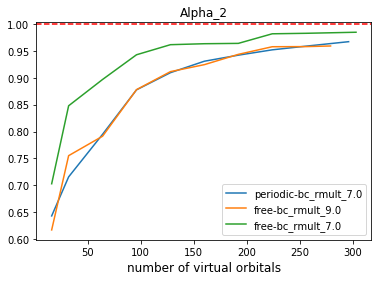

In [6]:
%matplotlib inline
alphaInd = 2
for bc in statPol:
    for r,s in statPol[bc].iteritems():
        nalpha = s.keys()
        nalpha.sort()
        print 'bc : ', bc, ' rmult = ', r, 'nalpha = ', nalpha
        val = [] 
        for na in nalpha:
            val.append(s[na][alphaInd])
        val = np.array(val)/statPol_ref[alphaInd]
        plt.plot(nalpha,val,label=bc+'_rmult_'+str(r))
plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('number of virtual orbitals', size=12)
plt.title('Alpha_'+str(alphaInd))
plt.legend()

It is interesting to perform the same plot in function of the energy

In [7]:
R.engMax(Data['free-bc'][7.0],numOrb,32)

8.6421718443782112

bc :  periodic-bc  rmult =  7.0 emax =  [2.6672106440028158, 5.2218160404593901, 7.7144062661554527, 11.710592566463321, 13.199349917397839, 15.951539363135284, 17.763164604488804, 19.601837512350389, 20.862938164094253, 24.404509573511138]
bc :  free-bc  rmult =  9.0 emax =  [3.6716402668845434, 5.4820832514334379, 8.8989781346906742, 11.211925798428849, 13.703921739448221, 16.112665759400539, 18.154253352748867, 20.143045157365865, 21.730045603572854, 23.475958406502457]
bc :  free-bc  rmult =  7.0 emax =  [5.6075245995729288, 8.6421718443782112, 14.441475837420493, 17.98130707653603, 21.8635160883255, 25.610339556955523, 29.281299232055698, 31.815552411348662, 34.523930354607771, 39.092177066279902]


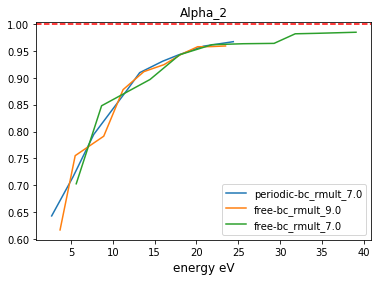

In [8]:
%matplotlib inline
alphaInd = 2
for bc in statPol:
    for r,s in statPol[bc].iteritems():
        nalpha = s.keys()
        nalpha.sort()
        emax = [R.engMax(Data[bc][r],numOrb,na) for na in nalpha]
        print 'bc : ', bc, ' rmult = ', r, 'emax = ', emax
        val = [] 
        for na in nalpha:
            val.append(s[na][alphaInd])
        val = np.array(val)/statPol_ref[alphaInd]
        plt.plot(emax,val,label=bc+'_rmult_'+str(r))
plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('energy eV', size=12)
plt.title('Alpha_'+str(alphaInd))
plt.legend()

## Stability of the  spectrum

Firstly we analyze the convergence of the spectrum in function of the number of virtual orbitals

In [9]:
bc = 'free-bc'
r = 7.0
part = 'imagPart'

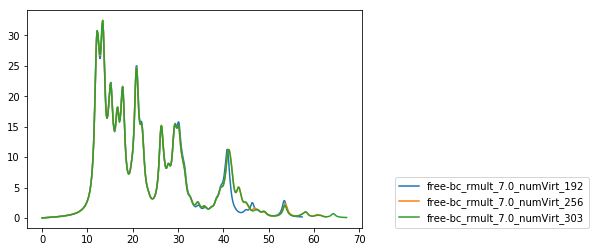

In [10]:
nVmax = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
na_plot = [192,256,nVmax]
for na in na_plot:
    if na in spectrum[bc][r]:
        plt.plot(spectrum[bc][r][na]['omega'],spectrum[bc][r][na][part],label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
plt.legend()
plt.legend(loc=(1.1,0))

The analysis of the plot for the two values of rmult show that:
* For rmult = 7.0 the spectrum is stable up to 40 eV
* For rmult = 9.0 the spectrum is stable up to 30 eV
These results indicate that it is interesting to compare the spectrum for the two values of rmult up to 30 eV

Then we compare the spectrum with different boundary conditions

In [11]:
part = 'imagPart'

periodic-bc
free-bc


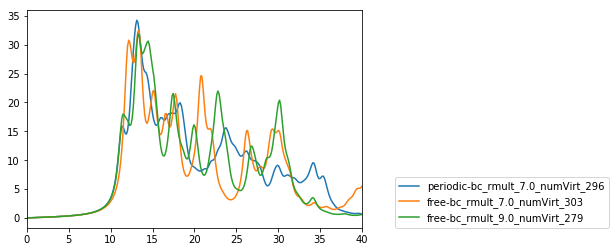

In [12]:
for bc,sim in simSetup.iteritems():
    print bc
    for r in sim['rmult']:
        na = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
        plt.plot(spectrum[bc][r][na]['omega'],spectrum[bc][r][na][part],label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
plt.legend()
plt.xlim(0,40)
plt.legend(loc=(1.1,0))

In [13]:
#spectrum['free-bc'][7.0][simSetup['free-bc']['nVirtMax'][simSetup['free-bc']['rmult'].index(7.0)]]

## Comparison of the low energy excitations

We set the number of virtual orbitals with negative energy equal to 2, as obtained in the free-bc simulation (the periodic code gives 3, but we use the same value for both the cases)

In [14]:
numVirtBound = 2

We compute the some over bound for each case

In [27]:
sob = {}
for bc,e in excitations.iteritems():
    sob[bc] = {}
    for r,val in e.iteritems():
        sob[bc][r] = R.evalSob(numVirtBound,val)

[64, 128, 192, 256, 296]
Number of distinct transisitons =  56
Number of transisitons removed =  0
[64, 128, 192, 256, 279]
Number of distinct transisitons =  56
Number of transisitons removed =  0
[64, 128, 192, 256, 303]
Number of distinct transisitons =  66
Number of transisitons removed =  0


In [32]:
bc = 'free-bc'
rmult = 7
nalpha = excitations[bc][rmult].keys()
nalpha.sort()
print nalpha
sobStability = R.evalSobStability(sob[bc][r],nalpha)

[64, 128, 192, 256, 303]


In [33]:
derThreshold = 1.0e-4
highDerivativeTr = []
for tr, s in sobStability.iteritems():
    if abs(s['derivative']) > derThreshold:
        highDerivativeTr.append(tr)
highDerivativeTr

['2to7-1', '2to1-0+2to2-0']

In [ ]:
#####################################################################################################

## Comparison of the lower energy excitations

To undestand the effect of rmult on the excitations of the system we star by comparing the lower energy exctitations. Since the usage of more than one value of na can remove some the excitations we perform this comparison using a dictionary that contains, for each value of rmult, only the excitations computed with the highest number of virtual orbitals.

In [50]:
excitations = {}

%cd $outputpath
for ind, r in enumerate(rmult):
    #filename = 'log/excitations_rmult'+str(r)+'.yaml '
    filename = 'log/excitations_singlena_rmult'+str(r)+'.yaml '
    excitations[r] = Yaml.load(filename)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2



First of all we display the lower energy transitions for both values of the box

In [51]:
allTr = {}
trEnergy = {}
for r in rmult:
    allTr[r], trEnergy[r] = R.allTransitions(excitations[r])

In [52]:
numexc = 20
for ind in range(numexc):
    print 'lev : ',ind+1, 'Lab r=7 :',allTr[rmult[0]][ind], 'Lab r=9 : ',allTr[rmult[1]][ind], 'E(r=7) = ', trEnergy[rmult[0]][ind], 'dE = ', abs(trEnergy[rmult[1]][ind] - trEnergy[rmult[0]][ind]) 

lev :  1 Lab r=7 : 3,4to1,2-0 Lab r=9 :  3,4to1,2-0 E(r=7) =  7.30809173305 dE =  0.0300166690571
lev :  2 Lab r=7 : 5to1-0+5to2-0 Lab r=9 :  5to1-0+5to2-0 E(r=7) =  7.34378457737 dE =  0.0106894167869
lev :  3 Lab r=7 : 3,4to1,2-1 Lab r=9 :  3,4to1,2-1 E(r=7) =  8.43623824312 dE =  0.011099242685
lev :  4 Lab r=7 : 3,4to1,2-2 Lab r=9 :  3,4to1,2-2 E(r=7) =  8.43917784921 dE =  0.0111468176282
lev :  5 Lab r=7 : 5to1-1+5to2-1 Lab r=9 :  5to1-1+5to2-1 E(r=7) =  8.90000231349 dE =  0.0296469900353
lev :  6 Lab r=7 : 3,4to1,2-3+3,4to1,2-4 Lab r=9 :  3,4to1,2-3+3,4to1,2-4 E(r=7) =  9.35069114931 dE =  0.00112711302177
lev :  7 Lab r=7 : 3,4to1,2-5 Lab r=9 :  3,4to1,2-5 E(r=7) =  9.85047044711 dE =  0.0041152072531
lev :  8 Lab r=7 : 3,4to1,2-6 Lab r=9 :  3,4to1,2-6 E(r=7) =  9.85313464686 dE =  0.00418370847078
lev :  9 Lab r=7 : 2to1,2-1+2to1,2-0 Lab r=9 :  2to1-0+2to2-0 E(r=7) =  10.2326504097 dE =  0.0145459535511
lev :  10 Lab r=7 : 5to3-0 Lab r=9 :  5to3-0 E(r=7) =  10.9098389505 dE =

COMMENTS : 
* There are 17 excitations in which the lab is the same for both value of rmult
* Only for the first 9 excitations dE is lower than 0.1 eV

## Stability of the relevant excitations

To understand why the spectrum changes from rmult 7 to 9 we perform an analysis of the properties of the excitations that are relevant for the costruction of the spectrum e compare the results for the two values of rmult.

Now we start to analyze the transitions more relevant for the specrtum. We plot the oscillator strenght

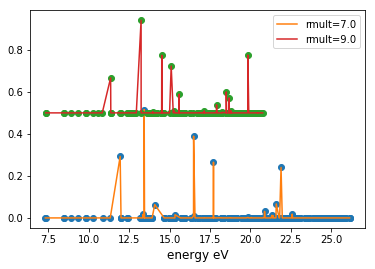

In [48]:
offs = 0.0
for r in rmult:
    allTr, trEnergy = R.allTransitions(excitations[r])
    na = excitations[r].keys()[-1]
    oscStrenght = []
    for tr in allTr:
        oscStrenght.append(excitations[r][na]['transitions'][tr]['oscStrenght'])
    plt.plot(trEnergy,offs+np.array(oscStrenght),'o')
    plt.plot(trEnergy,offs+np.array(oscStrenght),label = 'rmult='+str(r))
    #plt.plot(offs+np.array(oscStrenght),'o')
    #plt.plot(offs+np.array(oscStrenght),label = 'rmult='+str(r))
    offs+=0.5
plt.legend()
plt.xlabel('energy eV', size=12)
plt.show()

Build the dictionary with the most relevant transitions

In [27]:
relTransitions = {}
relEnergy = {}
relOscStrenght = {}
for r in rmult:
    relTransitions[r] = []
    relEnergy[r] = []
    relOscStrenght[r] = []
    na = excitations[r].keys()[-1]
    allTr, trEnergy = R.allTransitions(excitations[r])
    for ind,tr in enumerate(allTr):
        osc = excitations[r][na]['transitions'][tr]['oscStrenght'] 
        if  osc > 0.1:
            relTransitions[r].append(tr)
            relEnergy[r].append(trEnergy[ind])
            relOscStrenght[r].append(osc)
        

In [28]:
for r in rmult:
    print relTransitions[r]
    print relEnergy[r]
    print relOscStrenght[r]

['5to4-0', '3,4to5,6-6+3,4to5,6-5', '2to7-1', '5to22-0', '2to30-0']
[11.94476225779843, 13.431632699878232, 16.492041953851057, 17.72398010006172, 21.907486314446217]
[0.2926858196809133, 0.5155401131505235, 0.3891823859612723, 0.2651982944933355, 0.2402204650804506]
['5to4-0', '2to1-1+2to2-1', '2,5to4,22-1', '3to12-1+4to12-1', '5to71-0']
[11.354487481245043, 13.241617360350151, 14.519996884955464, 15.104261081447103, 19.852670105093267]
[0.16684251889565177, 0.4410122563599942, 0.2741581074909661, 0.22246241572469436, 0.27540134296020063]
